In [1]:
import os
import gc
import csv
import sys
import time
import h5py
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
# from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from scipy.stats import pearsonr
import pickle 

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

In [2]:
_ = np.array([0, 2, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 33, 35, 37, 39, 41, 43, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 4, 5, 6, 7, 8, 9, 10, 11, 28, 45])
# read the fiber name
l_idx = [1,3,13,15,17,19,25,27,30,32,36,38,40,42,44,47,49,51,53,55,57,59,61,63,65,67,69,71]
r_idx = [2,4,14,16,18,24,26,28,31,35,37,39,41,43,45,48,50,52,54,56,58,60,62,64,66,68,70,72]
m_idx = [4,5,6,7,8,9,10,11]
l_idx = np.array(l_idx)
r_idx = np.array(r_idx)
m_idx = np.array(m_idx)
l_idx = l_idx-1
r_idx = r_idx-1
label_f = open('/n02dat01/users/dyli/Grad_data/support_data/fiber_name_ori_nonum_nohemi.txt', 'r')
label_name = label_f.readlines()
label_name = [' '.join([i.strip() for i in price.strip().split('\n')]) for price in label_name]
label_name_lm = [label_name[l_idx[i]] for i in range(len(l_idx))] + [label_name[m_idx[i]] for i in range(len(m_idx))]
print(f'the number of fiber: {len(label_name_lm)}')

new_fiber_idx = []
for fi,ff in enumerate(_):
    if ff in list(l_idx)+list(m_idx): new_fiber_idx.append(fi)
new_fiber_idx = np.array(new_fiber_idx)
print(new_fiber_idx.shape)

the number of fiber: 36
(36,)


In [3]:
# the medial wall
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

In [4]:
surface_name = 'white'

# Figure 2C.

Ref link: https://doi.org/10.1038/nn.4135

Ref title: Functional connectome fingerprinting: identifying individuals using patterns of brain connectivity

(36,)


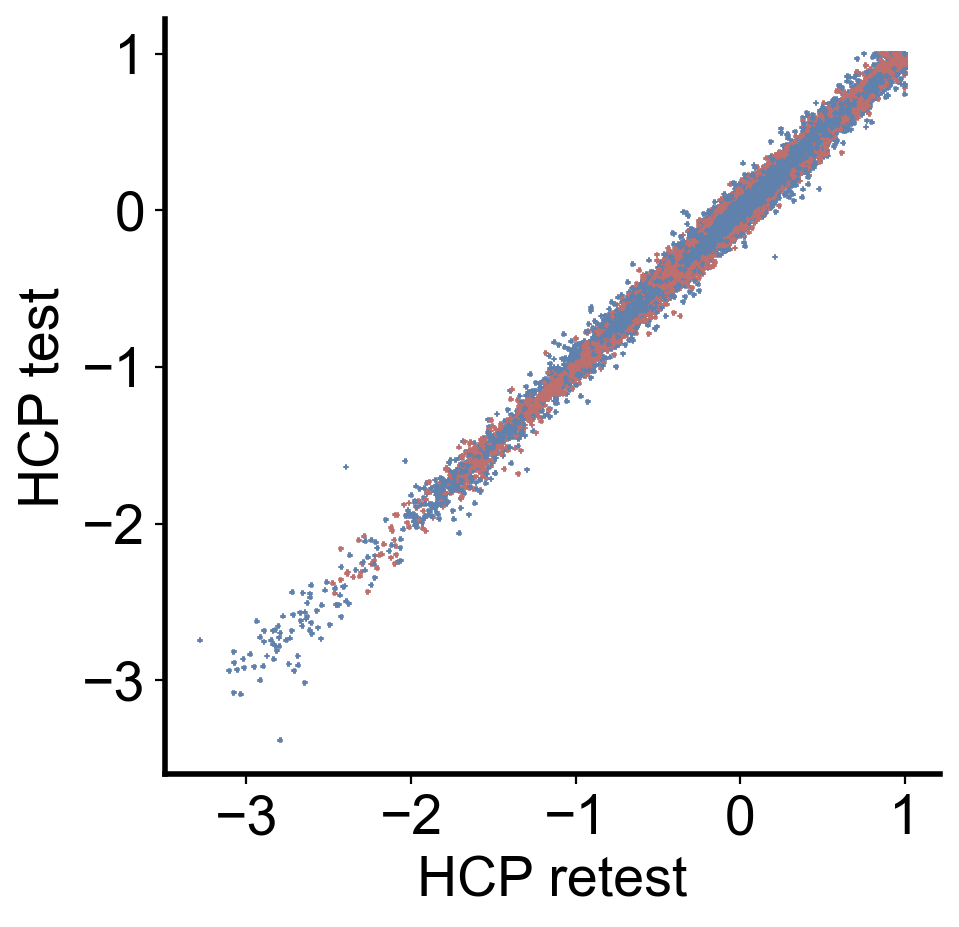

In [12]:
import pandas as pd
import seaborn as sns

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

fiber_label_colormap = ['#bd706e', '#6181ad', '#bd706e', '#6181ad', '#6181ad']
fiber_label = np.array([
              1,1,2,2,3,3,3,3,3,3,3,
              3,1,1,4,4,1,1,4,4,
              3,4,4,1,1,1,1,4,4,4,
              1,1,4,4,1,1,1,1,1,1,
              2,2,1,1,3,2,2,2,2,2,
              2,2,2,2,2,2,2,5,5,5,
              5,5,5,5,5,5,5,5,5,5,
              5])
fiber_label = fiber_label-1
fiber_label_lm = np.array(list(fiber_label[l_idx]) + list(fiber_label[m_idx]))
print(fiber_label_lm.shape)
palette_fiber = [fiber_label_colormap[fiber_label_lm[i]] for i in range(len(label_name_lm))]

plt.figure(figsize=(5, 5),dpi=200)

_x = np.array([int(35-i) for i in range(36)])
np.random.shuffle(_x)
for fiberi in list(_x):
    corr_pair = np.zeros((2, len(namelist)*200))
    for i,sub in enumerate(namelist):
        para1 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
        para2 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/retest/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
        # normalization
        para1 = para1/np.max(para1, axis=0)
        para2 = para2/np.max(para2, axis=0)
        # choose the fiber
        para1 = para1[:, fiberi]
        para2 = para2[:, fiberi]
        # data for plot
        corr_pair[0, i*200:(i+1)*200] = para1
        corr_pair[1, i*200:(i+1)*200] = para2

    plt.scatter(corr_pair[0,:], 
                corr_pair[1,:], 
                s=1, 
                marker='+', 
                c=[f'{palette_fiber[fiberi]}' for i in range(len(namelist)*200)], 
                linewidths=[2])
    
ax1 = plt.gca()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('HCP test', fontsize=20)
plt.xlabel('HCP retest', fontsize=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth('2.0')
ax1.spines['left'].set_linewidth('2.0')
plt.show()

# Figure 2D.

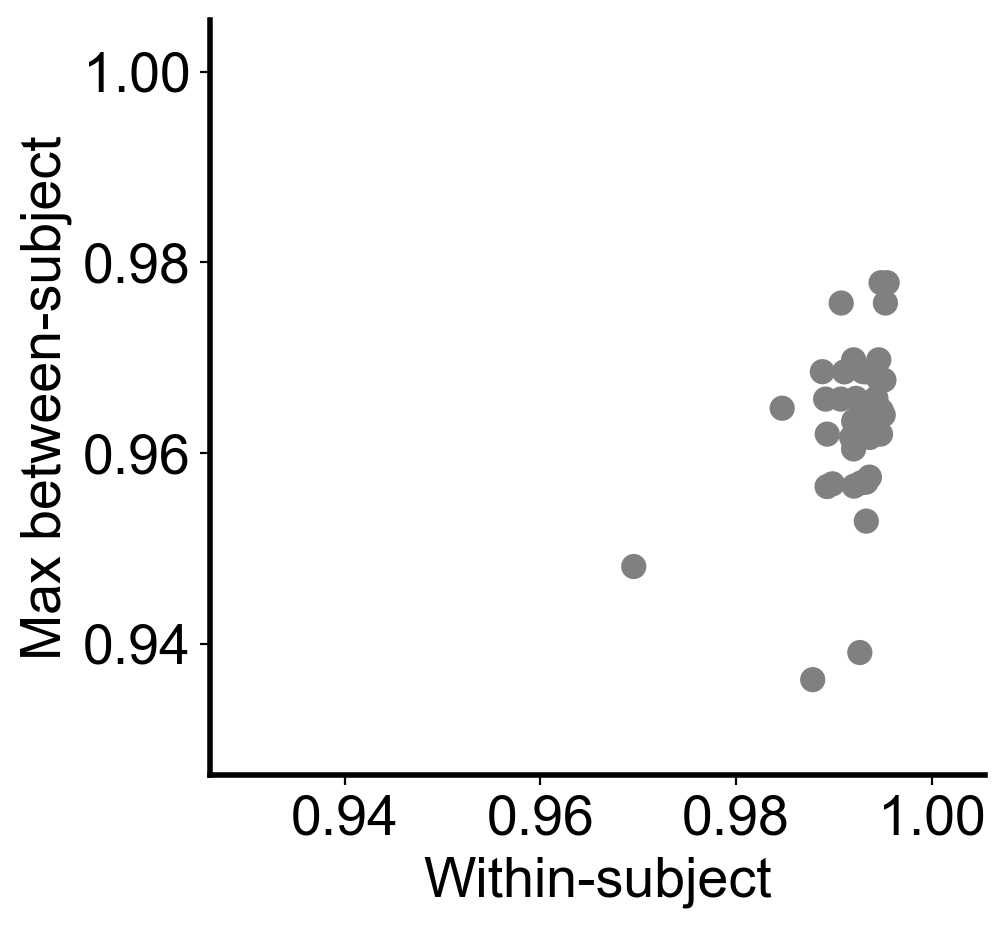

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


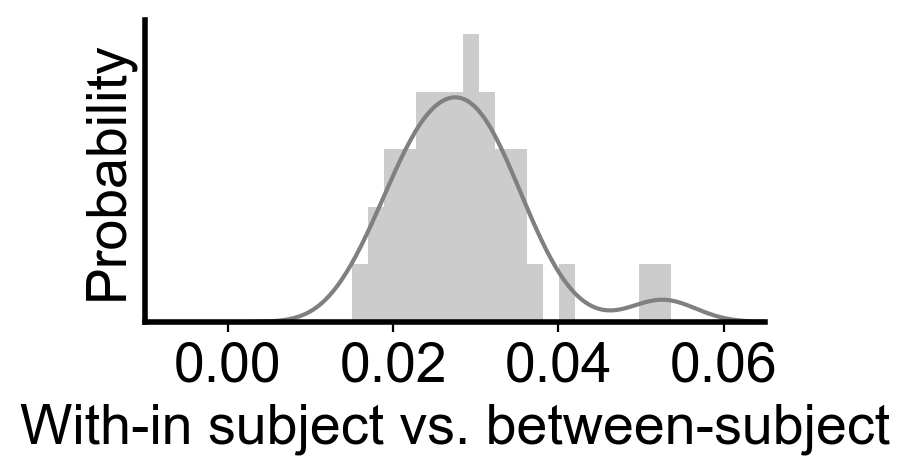

In [9]:
import pandas as pd
import seaborn as sns

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

indi_corr = np.zeros((len(namelist), len(namelist)))
for i,subi in enumerate(namelist):
    parai = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{subi}/FP_{subi}_predict_by_200_group_{surface_name}mode_para_L.npy')
    parai = parai/np.max(parai, axis=0)
    for k,subk in enumerate(namelist):
        parak = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{subk}/FP_{subk}_predict_by_200_group_{surface_name}mode_para_L.npy')
        parak = parak/np.max(parak, axis=0)
        # align
        if parai.shape[1]>parak.shape[1]: parai = parai[:, 0:parak.shape[1]]
        if parai.shape[1]<parak.shape[1]: parak = parak[:, 0:parai.shape[1]]
        indi_corr[i, k] = np.corrcoef(parai.flatten(), parak.flatten())[0,1]

for i,sub in enumerate(namelist):
    para1 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
    para2 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/retest/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
    para1 = para1/np.max(para1, axis=0)
    para2 = para2/np.max(para2, axis=0)
    # align
    if para1.shape[1]>para2.shape[1]: para1 = para1[:, 0:para2.shape[1]]
    if para1.shape[1]<para2.shape[1]: para2 = para2[:, 0:para1.shape[1]]
    indi_corr[i, i] = np.corrcoef(para1.flatten(), para2.flatten())[0,1]

corr_pair = np.zeros((len(namelist),2))
for i in range(len(namelist)):
    corr_pair[i,1] = indi_corr[i,i]
    _ = indi_corr[i,:]
    _[i] = -2
    corr_pair[i,0] = np.max(_)

df = pd.DataFrame(corr_pair, columns=['between-sub', 'in-sub'])

plt.figure(figsize=(5, 5),dpi=200)
plt.scatter(corr_pair[:,1], corr_pair[:,0], s=50, c=['grey' for i in range(len(namelist))], linewidths=[2])
plt.ylim([np.min(corr_pair)-0.01,np.max(corr_pair)+0.01])
plt.xlim([np.min(corr_pair)-0.01,np.max(corr_pair)+0.01])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Max between-subject', fontsize=20)
plt.xlabel('Within-subject', fontsize=20)
ax1 = plt.gca()
x_major_locator = MultipleLocator(0.02)
ax1.xaxis.set_major_locator(x_major_locator)
y_major_locator = MultipleLocator(0.02)
ax1.yaxis.set_major_locator(y_major_locator)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth('2.0')
ax1.spines['left'].set_linewidth('2.0')
plt.show()

plt.figure(figsize=(4, 2),dpi=200)
cha = corr_pair[:,1] - corr_pair[:,0]
sns.distplot(cha, bins=20, hist=True, kde=True, rug=False, fit=None, 
            hist_kws=None, kde_kws=None, rug_kws=None,fit_kws=None, color='grey', vertical=False,
            norm_hist=False, axlabel=None,label=None, ax=None)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim([-0.01,0.065])
plt.yticks([])
plt.ylabel('Probability', fontsize=20)
plt.xlabel('With-in subject vs. between-subject', fontsize=20)
ax2 = plt.gca()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth('2.0')
ax2.spines['left'].set_linewidth('2.0')

In [5]:
import pandas as pd
import seaborn as sns

# read the sublist
list_path = '/n01dat01/dyli/multi/scripts/data_preprocess/sub_list/HCP_retest.txt'
with open( list_path, 'r' ) as f:
    namelist = [ str( line.strip()) for line in f.readlines() ]

for fiberi, fibern in enumerate(label_name_lm):
    indi_corr = np.zeros((len(namelist), len(namelist)))
    for i,subi in enumerate(namelist):
        parai = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{subi}/FP_{subi}_predict_by_200_group_{surface_name}mode_para_L.npy')
        parai = parai/np.max(parai, axis=0)
        for k,subk in enumerate(namelist):
            parak = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{subk}/FP_{subk}_predict_by_200_group_{surface_name}mode_para_L.npy')
            parak = parak/np.max(parak, axis=0)
            # align
            if parai.shape[1]>parak.shape[1]: parai = parai[:, 0:parak.shape[1]]
            if parai.shape[1]<parak.shape[1]: parak = parak[:, 0:parai.shape[1]]
            indi_corr[i, k] = np.corrcoef(parai[:, fiberi], parak[:, fiberi])[0,1]

    for i,sub in enumerate(namelist):
        para1 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/test/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
        para2 = np.load(f'/n01dat01/dyli/multi/HCP_test_retest/retest/{sub}/FP_{sub}_predict_by_200_group_{surface_name}mode_para_L.npy')
        para1 = para1/np.max(para1, axis=0)
        para2 = para2/np.max(para2, axis=0)
        # align
        if para1.shape[1]>para2.shape[1]: para1 = para1[:, 0:para2.shape[1]]
        if para1.shape[1]<para2.shape[1]: para2 = para2[:, 0:para1.shape[1]]
        indi_corr[i, i] = np.corrcoef(para1[:, fiberi], para2[:, fiberi])[0,1]

    corr_pair = np.zeros((len(namelist),2))
    for i in range(len(namelist)):
        corr_pair[i,1] = indi_corr[i,i]
        _ = indi_corr[i,:]
        _[i] = -2
        corr_pair[i,0] = np.max(_)

    df = pd.DataFrame(corr_pair, columns=['between-sub', 'in-sub'])
    df.to_csv(f'/n01dat01/dyli/multi/results_data/testRetest/HCP_{fibern}.csv')

In [36]:
results = np.zeros(36)
for fiberi, fibern in enumerate(label_name_lm):
    df = pd.read_csv(f'/n01dat01/dyli/multi/results_data/testRetest/HCP_{fibern}.csv')
    df = df.drop(columns=['Unnamed: 0'])
    data = df.values
    for i in range(40):
        if data[i,0]<data[i,1]: results[fiberi] +=1
    print(fibern, results[fiberi]/40)
print(results/40)

AF 1.0
ATR 1.0
CG 1.0
CST 1.0
MLF 1.0
FPT 1.0
IFO 1.0
ILF 1.0
OR 1.0
POPT 1.0
SLF_I 1.0
SLF_II 1.0
SLF_III 1.0
STR 1.0
UF 0.95
T_PREF 1.0
T_PREM 1.0
T_PREC 1.0
T_POSTC 1.0
T_PAR 1.0
T_OCC 1.0
ST_FO 0.95
ST_PREF 1.0
ST_PREM 1.0
ST_PREC 1.0
ST_POSTC 1.0
ST_PAR 1.0
ST_OCC 1.0
CA 0.975
CC_1 0.8
CC_2 1.0
CC_3 1.0
CC_4 1.0
CC_5 1.0
CC_6 1.0
CC_7 0.975
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    0.95  1.    1.    1.    1.    1.    1.    0.95  1.    1.
 1.    1.    1.    1.    0.975 0.8   1.    1.    1.    1.    1.    0.975]


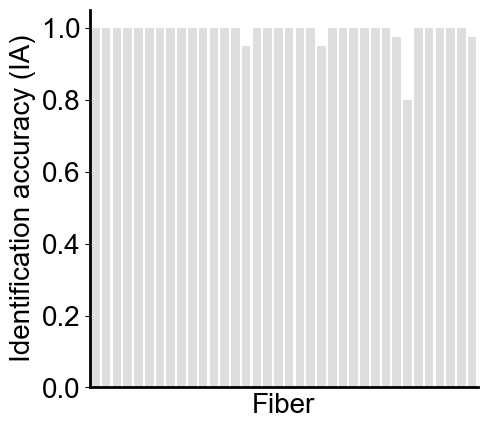

In [37]:
df_ii = pd.DataFrame(columns=['fiber-name', 'identify-index'])
for _i,_name in enumerate(label_name_lm):
    df_ii.loc[len(df_ii.index)] = [_name, results[_i]/40]

fig,ax = plt.subplots(figsize=(5,5),dpi=100,facecolor="w")
palette = ['#dedede' for i in range(36)]
ax = sns.barplot(data=df_ii,
                x='fiber-name',
                y='identify-index', 
                palette=palette,
                estimator=np.mean, ci="sd", 
                ax=ax,)
ax=plt.gca()
plt.yticks(fontsize=20)
plt.xticks([],fontsize=15, rotation=90)
plt.xlabel('Fiber', fontsize=20)
plt.ylabel('Identification accuracy (IA)', fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
fig.savefig('figure3_each_fiber_identify_results.png', transparent = True, bbox_inches = 'tight',dpi = 300)
plt.show()

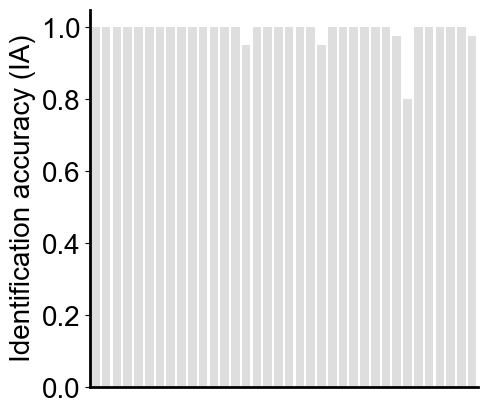

In [50]:
df_ii = pd.DataFrame(columns=['fiber-name', 'identify-index'])
for _i,_name in enumerate(label_name_lm):
    df_ii.loc[len(df_ii.index)] = [_name, results[_i]/40]

fig,ax = plt.subplots(figsize=(5,5),dpi=100,facecolor="w")
palette = ['#dedede' for i in range(36)]
ax = sns.barplot(data=df_ii,
                x='fiber-name',
                y='identify-index', 
                # hue='feature_name',
                palette=palette,
                estimator=np.mean, ci="sd", # capsize=.1,errwidth=1,errcolor="k",
                ax=ax,)
                # **{"edgecolor":"k","linewidth":1})
ax=plt.gca()
plt.yticks(fontsize=20)
plt.xticks([],fontsize=15, rotation=90)
# y_major_locator=MultipleLocator(0.05)
# ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel('Fiber', fontsize=20)
plt.ylabel('Identification accuracy (IA)', fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
fig.savefig('figure3_each_fiber_identify_results.png', transparent = True, bbox_inches = 'tight',dpi = 300)
plt.show()